In [49]:
!pip install numpy matplotlib
!pip install fenics
!pip install scipy
!docker run -ti -v $PWD:/home/fenics/shared -w /home/fenics/shared quay.io/fenicsproject/stable:current


/bin/bash: line 1: docker: command not found


In [50]:
!pip install meshpy


In [51]:
!pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [52]:
import os
os.environ["PYTORCH_DISABLE_META_OVERLOAD"] = "1"

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda
Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

real_Du = 0.01
real_Dv = 0.02
real_rho = 1.0
real_ku= 1.0
real_kappa = 0.2
real_mu = 1.0


def true_u(x, y, t):
    return torch.sin(np.pi * x) * torch.sin(np.pi * y) * torch.exp(-t)

def true_v(x, y, t):
    return torch.sin(np.pi * x) * torch.exp(-t)

class PINN_GM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

        self.log_Du = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_rho = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.log_ku = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_mu = nn.Parameter(torch.log(torch.tensor(0.5)))


    @property
    def Du(self):
        return torch.exp(self.log_Du)

    @property
    def Dv(self):
        return torch.exp(self.log_Dv)

    @property
    def rho(self):
        return torch.exp(self.log_rho)

    @property
    def ku(self):
        return torch.exp(self.log_ku)

    @property
    def kappa(self):
        return torch.exp(self.log_kappa)

    @property
    def mu(self):
        return torch.exp(self.log_mu)


    def forward(self, x, y, t):
        input = torch.cat([x, y, t], dim=1)
        return self.net(input)


def compute_residuals(model, x, y, t):
    input = torch.cat([x, y, t], dim=1).requires_grad_(True)
    output = model(x, y, t)
    u = output[:, 0:1]
    v = output[:, 1:2]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_lap = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] + \
            torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    v_lap = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0] + \
            torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    eps = 1e-6
    u_concentration = u_t - model.Du * u_lap - model.rho * (v**2 - model.ku * u)
    v_concentration = v_t - model.Dv * v_lap - model.rho * ((v**2) / (u * (1 + model.kappa * v**2) + eps) - model.mu * v)

    return u_concentration, v_concentration, u, v


def compute_loss(model, x, y, t, u_data, v_data):
    u_concentration, v_concentration, u_pred, v_pred = compute_residuals(model, x, y, t)
    loss_pde = torch.mean(u_concentration**2) + torch.mean(v_concentration**2)
    loss_data = torch.mean((u_pred - u_data)**2) + torch.mean((v_pred - v_data)**2)
    return loss_pde + loss_data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 1000
x = torch.rand(N, 1, device=device) * 2 - 1
y = torch.rand(N, 1, device=device) * 2 - 1
t = torch.rand(N, 1, device=device)

x_tensor = x.clone().detach().requires_grad_(True)
y_tensor = y.clone().detach().requires_grad_(True)
t_tensor = t.clone().detach().requires_grad_(True)

u_tensor = true_u(x, y, t).detach()
v_tensor = true_v(x, y, t).detach()


model = PINN_GM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
total_count_iterations = 600

for epoch in range(total_count_iterations):
    optimizer.zero_grad()
    loss = compute_loss(model, x_tensor, y_tensor, t_tensor, u_tensor, v_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        print(f"  Du = {model.Du.item():.4f}  (True: {real_Du})")
        print(f"  rho = {model.rho.item():.4f}  (True: {real_rho})")
        print(f"  ku = {model.ku.item():.4f}  (True: {real_ku})")
        print()


Epoch 0, Loss: 0.354720
  Du = 0.1001  (True: 0.01)
  rho = 0.4995  (True: 1.0)
  ku = 0.4995  (True: 1.0)

Epoch 200, Loss: 0.715770
  Du = 0.0813  (True: 0.01)
  rho = 0.4898  (True: 1.0)
  ku = 0.4034  (True: 1.0)

Epoch 400, Loss: 0.695054
  Du = 0.0690  (True: 0.01)
  rho = 0.4829  (True: 1.0)
  ku = 0.3428  (True: 1.0)



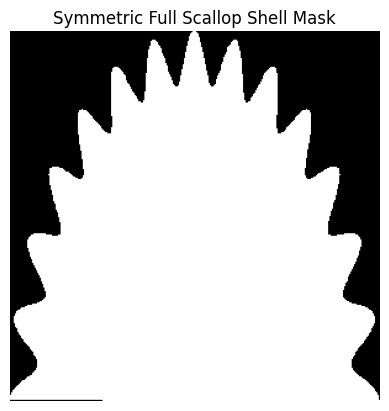

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np
import cv2
import matplotlib.pyplot as plt

def shell_mask_generation_drawing(size=300, n_ridges=24, ripple_amp=0.08, radius=0.9):
    theta = np.linspace(0, np.pi, 800)
    r = radius * (1 + ripple_amp * np.cos(n_ridges * theta))

    up_bound_x_axis = r * np.cos(theta)
    up_bound_y_axis = r * np.sin(theta)

    total_x_axis = np.concatenate([up_bound_x_axis, [0]])
    total_y_axis = np.concatenate([up_bound_y_axis, [0]])

    # Normalize to image coordinates
    normalized_x_values = (total_x_axis - total_x_axis.min()) / (total_x_axis.max() - total_x_axis.min())
    normalized_y_values = (total_y_axis - total_y_axis.min()) / (total_y_axis.max() - total_y_axis.min())

    fig_x = normalized_x_values * (size - 1)
    fig_y = (1 - normalized_y_values) * (size - 1)

    contour = np.array([np.stack([fig_x, fig_y], axis=1)], dtype=np.int32)

    # Create mask
    mask = np.zeros((size, size), dtype=np.uint8)
    cv2.fillPoly(mask, contour, 1)
    return mask

mask = shell_mask_generation_drawing(size=300, n_ridges=28, ripple_amp=0.08)
plt.imshow(mask, cmap='gray')
plt.title("Symmetric Full Scallop Shell Mask")
plt.axis('off')
plt.show()




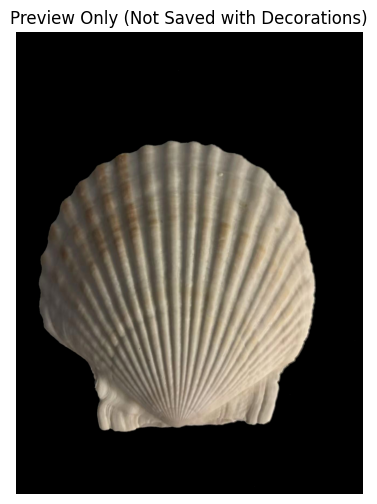

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

path_fig = "image1.jpg"
img = io.imread(path_fig)
rgb_figure = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) if img.shape[-1] == 4 else img

threshold = 50
modified_mask_lighter = np.any(rgb_figure > threshold, axis=2)

result = np.zeros_like(rgb_figure)
result[modified_mask_lighter] = rgb_figure[modified_mask_lighter]

plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.axis('off')
plt.title("Preview Only (Not Saved with Decorations)")
plt.show()

cv2.imwrite("image2.jpg", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))


<ipython-input-56-2651932411>:14: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(edges, square(3))


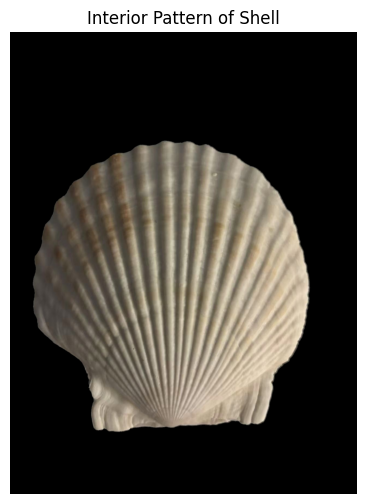

<Figure size 640x480 with 0 Axes>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, measure, filters
from skimage.morphology import closing, square

img = io.imread('image2.jpg')
rgb_figure = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) if img.shape[-1] == 4 else img
gray = cv2.cvtColor(rgb_figure, cv2.COLOR_RGB2GRAY)

edges = cv2.Canny(gray, 50, 150)
closed = closing(edges, square(3))
contours, _ = cv2.findContours(closed.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

shell_pattern_trajectories = max(contours, key=cv2.contourArea)

mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.fillPoly(mask, [shell_pattern_trajectories], 255)

masked_image = cv2.bitwise_and(rgb_figure, rgb_figure, mask=mask)

plt.figure(figsize=(6,6))
plt.imshow(masked_image)
plt.title("Interior Pattern of Shell")
plt.axis('off')
plt.show()
plt.savefig('shell_masked.png')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

gray_shell = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)

ys, xs = np.nonzero(gray_shell)
values = gray_shell[ys, xs] / 255.0

H, W = gray_shell.shape
normalized_x_values = (xs / W) * 2 - 1
normalized_y_values = (ys / H) * 2 - 1
normalized_t = np.zeros_like(normalized_x_values)

x_tensor = torch.tensor(normalized_x_values[:, None], dtype=torch.float32)
y_tensor = torch.tensor(normalized_y_values[:, None], dtype=torch.float32)
t_tensor = torch.tensor(normalized_t[:, None], dtype=torch.float32)
u_tensor = torch.tensor(values[:, None], dtype=torch.float32)

print(x_tensor)

tensor([[-0.1125],
        [-0.1109],
        [-0.1094],
        ...,
        [-0.3594],
        [-0.3578],
        [-0.3609]])


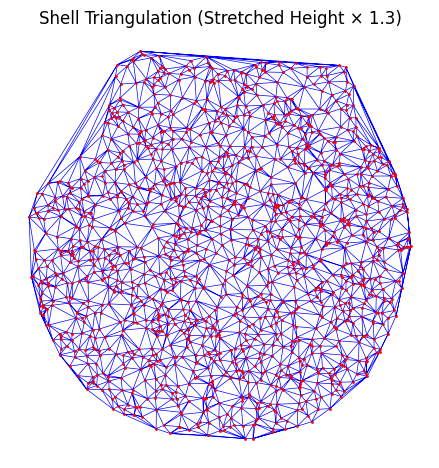

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from skimage import io

path_fig = "image2.jpg"
img = io.imread(path_fig)
rgb_figure = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) if img.shape[-1] == 4 else img
gray = cv2.cvtColor(rgb_figure, cv2.COLOR_RGB2GRAY)


_, thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shell_pattern_trajectories = max(contours, key=cv2.contourArea)

mask = np.zeros_like(gray)
cv2.drawContours(mask, [shell_pattern_trajectories], -1, 255, thickness=cv2.FILLED)

ys, xs = np.where(mask == 255)
number_of_points_1 = min(1500, len(xs))
points_with_indices = np.random.choice(len(xs), size=number_of_points_1, replace=False)
sample_points = np.vstack((xs[points_with_indices], ys[points_with_indices])).T

h, w = mask.shape
normalized_points = sample_points.copy().astype(np.float32)
normalized_points[:, 0] = (normalized_points[:, 0] - w / 2) / (w / 2)
normalized_points[:, 1] = (normalized_points[:, 1] - h / 2) / (h / 2)

stretch_factor = 1.3
normalized_points[:, 1] *= stretch_factor

tri = Delaunay(normalized_points)

plt.figure(figsize=(6 * w / h, 6))
plt.triplot(normalized_points[:, 0], normalized_points[:, 1], tri.simplices, color='blue', linewidth=0.5)
plt.plot(normalized_points[:, 0], normalized_points[:, 1], 'o', markersize=1, color='red')
plt.title(f"Shell Triangulation (Stretched Height × {stretch_factor})")
plt.gca().set_aspect('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig("shell_triangulation_correct_aspect.png")
plt.show()


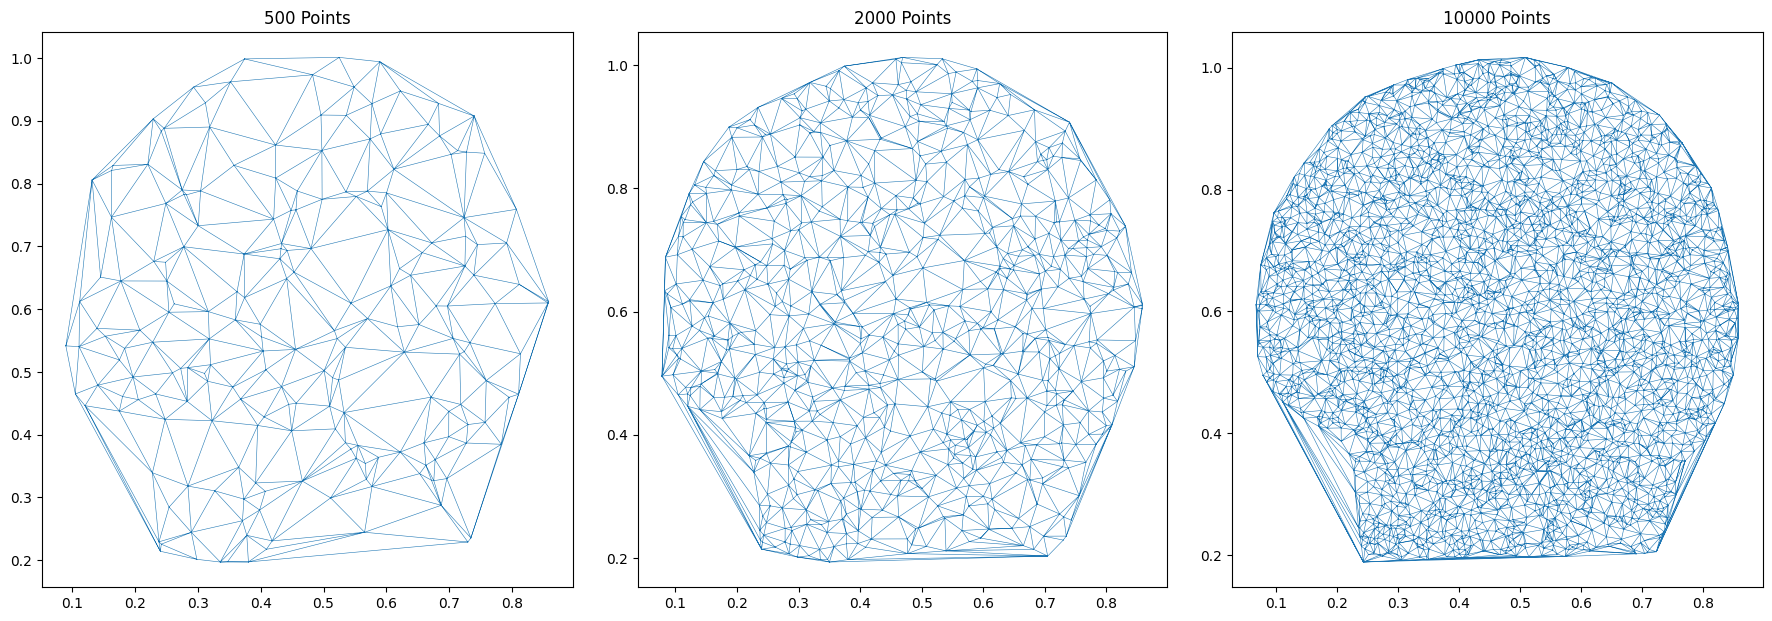

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import Delaunay


image_path = 'image2.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

h, w = shell_mask.shape
ratio_between_points = h / w

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig_shell_intensity = [500, 2000, 10000]

for i, num_points in enumerate(fig_shell_intensity):
    np.random.seed(0)


    meshes_tri_generated_randpoint = np.random.rand(num_points, 2)
    meshes_tri_generated_randpoint[:, 1] *= ratio_between_points

    px = (meshes_tri_generated_randpoint[:, 0] * w).astype(int)
    py = ((ratio_between_points - meshes_tri_generated_randpoint[:, 1]) * h / ratio_between_points).astype(int)

    px = np.clip(px, 0, w - 1)
    py = np.clip(py, 0, h - 1)
    bl1 = shell_mask[py, px] > 0
    tri_mesh_pt_real = meshes_tri_generated_randpoint[bl1]

    tri = Delaunay(tri_mesh_pt_real)
    axs[i].triplot(tri_mesh_pt_real[:, 0], tri_mesh_pt_real[:, 1], tri.simplices, linewidth=0.4)
    axs[i].set_aspect('equal')
    axs[i].set_title(f'{num_points} Points')

plt.tight_layout()
plt.savefig("triangulations2.png")
plt.show()


<Figure size 640x480 with 0 Axes>

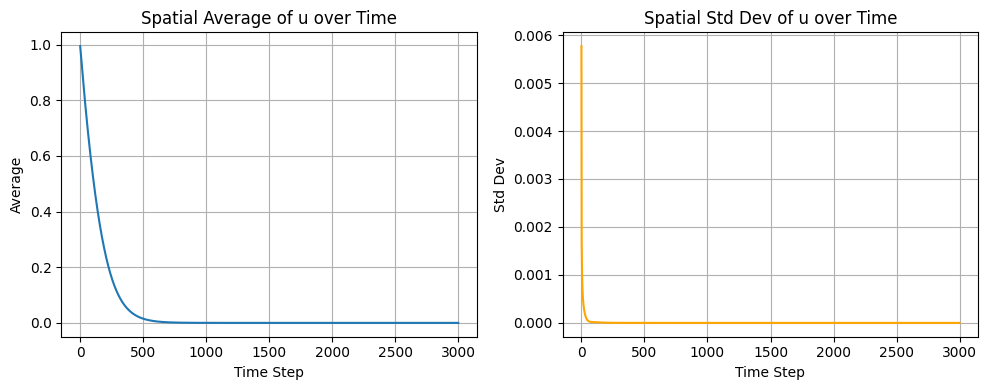

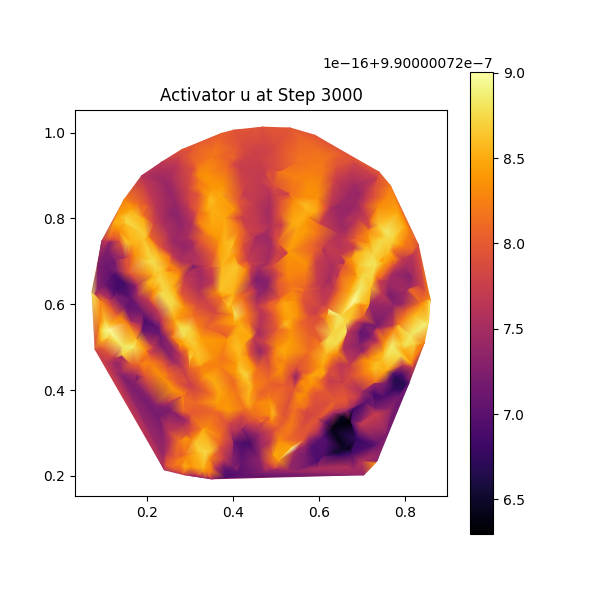

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import cv2

image_path = 'image2.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

h, w = shell_mask.shape
ratio_between_points = h / w

num_points = 3000
np.random.seed(0)
meshes_tri_generated_randpoint = np.random.rand(num_points, 2)
meshes_tri_generated_randpoint[:, 1] *= ratio_between_points

px = (meshes_tri_generated_randpoint[:, 0] * w).astype(int)
py = ((ratio_between_points - meshes_tri_generated_randpoint[:, 1]) * h / ratio_between_points).astype(int)

px = np.clip(px, 0, w - 1)
py = np.clip(py, 0, h - 1)

bl2 = shell_mask[py, px] > 0
points = meshes_tri_generated_randpoint[bl2]

tri = Delaunay(points)
triangles = tri.simplices

def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

def initialize_fowler_pattern(points):
    n = len(points)
    u0, v0 = 1.0, 1.0
    u = np.full(n, u0)
    v = np.full(n, v0)

    sized_x_axis_below = np.mean(points[:, 0])
    sized_y_axis_below = np.min(points[:, 1])
    center = np.array([sized_x_axis_below, sized_y_axis_below])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)

        multified_coef_vert = (y - sized_y_axis_below) / (np.max(points[:, 1]) - sized_y_axis_below + 1e-6)
        pert_term_additional = (1 - multified_coef_vert)
        perturb = 0.1 * np.cos(20 * angle) * pert_term_additional

        u[i] += perturb
        v[i] += perturb

    return u, v


u, v = initialize_fowler_pattern(points)


def fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt):
    u = np.clip(u, 1e-6, 1e3)
    v = np.clip(v, 1e-6, 1e3)

    u2 = u**2
    activation = (rho * u2) / ((v + h0) * (1 + kappa * u2 + rho0)) - mu2 * u
    inhibition = sigma + (rho * u2) / (1 + kappa * u2) - eta * v

    A_u = M + dt * Du * K
    A_v = M + dt * Dv * K
    b_u = M @ u + dt * M @ activation
    b_v = M @ v + dt * M @ inhibition

    u_new = spsolve(A_u, b_u)
    v_new = spsolve(A_v, b_v)
    return u_new, v_new


Du = 0.015
Dv = 0.0
rho = 0.1
kappa = 1.0
rho0 = 0.05
mu2 = 0.1
sigma = 0.0001
eta = 0.014
h0 = 0.1
dt = 0.1
T = 3000



import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image


from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas



snapshots = []
avg_u = []
std_u = []

for t in range(T + 1):
    if t % 500 == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(tri_meshes_count, u, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator u at Step {t}")
        plt.colorbar(im, ax=ax)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.close(fig)
        plt.savefig(f"fowler_step_{t}.png")

    if t < T:
        u, v = fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)
        avg_u.append(np.mean(u))
        std_u.append(np.std(u))



iterations_over_time = np.arange(0, T)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(iterations_over_time, avg_u, label='Spatial Average of u')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of u over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iterations_over_time, std_u, label='Spatial Std Dev of u', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of u over Time')
plt.grid(True)

plt.tight_layout()
plt.show()

snapshots[-1]

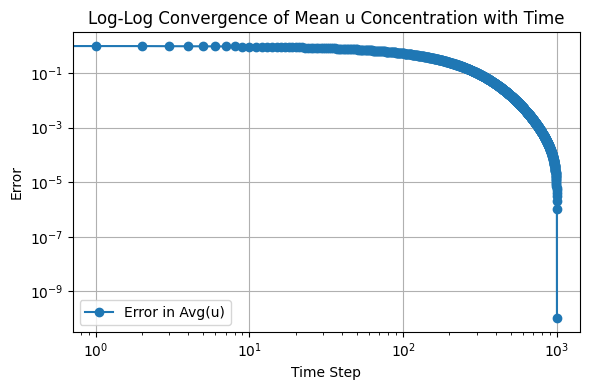

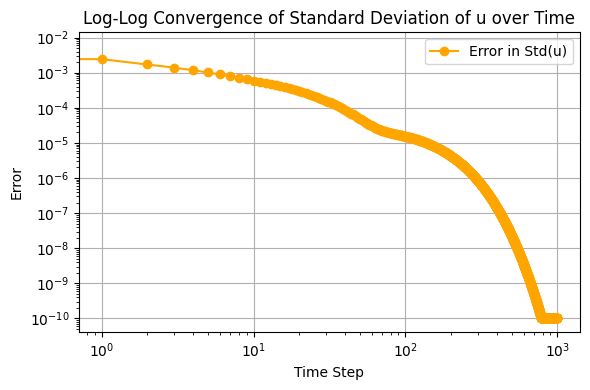

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

corresp_values1 = 1000
corresp_avg = avg_u[corresp_values1]
corresp_std = std_u[corresp_values1]

iterations_over_time2 = np.arange(0, corresp_values1 + 1)

errors_avg = np.abs(np.array(avg_u[:corresp_values1 + 1]) - corresp_avg)
errors_std = np.abs(np.array(std_u[:corresp_values1 + 1]) - corresp_std)

errors_avg = np.clip(errors_avg, 1e-10, None)
errors_std = np.clip(errors_std, 1e-10, None)

plt.figure(figsize=(6, 4))
plt.loglog(iterations_over_time2, errors_avg, label='Error in Avg(u)', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Mean u Concentration with Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.loglog(iterations_over_time2, errors_std, label='Error in Std(u)', marker='o', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Standard Deviation of u over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


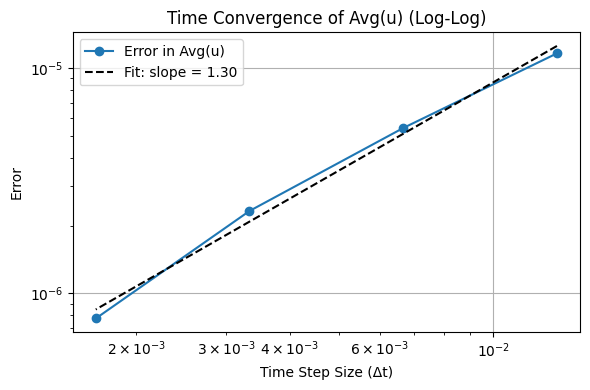

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iter_over_time_list = [75, 150, 300, 600, 1200]
last_avg_values = []

for num_steps in iter_over_time_list:
    dt = 1.0 / num_steps
    u, v = initialize_fowler_pattern(points)
    for t in range(num_steps):
        u, v = fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)
    last_avg_values.append(np.mean(u))

ref_value = last_avg_values[-1]
errors = [abs(val - ref_value) for val in last_avg_values[:-1]]

dt_list = [1.0 / n for n in iter_over_time_list[:-1]]

log_dt = np.log(dt_list)
log_err = np.log(errors)

slope, intercept = np.polyfit(log_dt, log_err, 1)
fit_line = np.exp(intercept) * np.array(dt_list)**slope

plt.figure(figsize=(6, 4))
plt.loglog(dt_list, errors, 'o-', label='Error in Avg(u)')
plt.loglog(dt_list, fit_line, 'k--', label=f'Fit: slope = {slope:.2f}')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Error')
plt.title('Time Convergence of Avg(u) (Log-Log)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def stability_model_check_out(mu2, eta, sigma, rho, rho0, kappa, h0, u0=0.1, tol=1e-10, max_iter=1000):
    u = u0
    for i in range(max_iter):
        v = (sigma + rho * u**2 / (1 + kappa * u**2)) / eta
        u_next = (mu2 / rho) * (v + h0) * (1 + kappa * u**2 + rho0)

        if abs(u_next - u) < tol:
            return u_next, i
        u = u_next
    raise RuntimeError("Fixed-point iteration did not converge")

mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1

u_star, num_iters = stability_model_check_out(mu2, eta, sigma, rho, rho0, kappa, h0)
v_star = (sigma + rho * u_star**2 / (1 + kappa * u_star**2)) / eta

u_star, v_star, num_iters


(6.600000239842878e-06, 0.5000000217800016, 2)

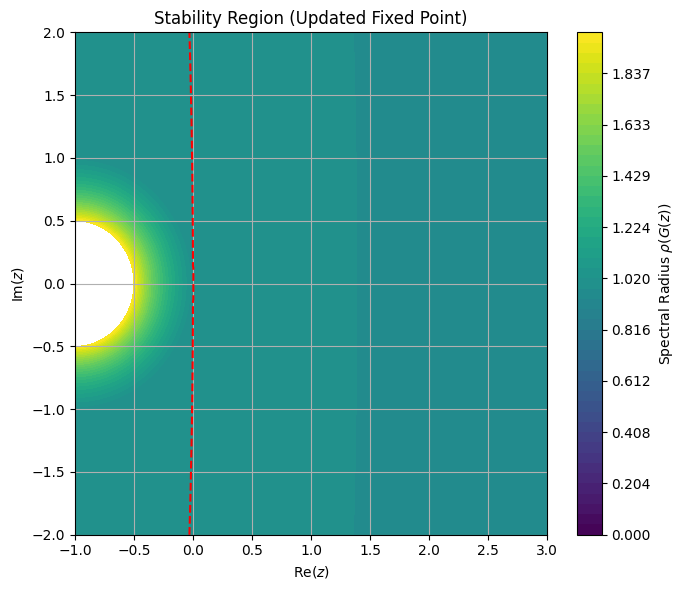

In [ ]:
from numpy.linalg import eigvals

u_star = 6.600000239842878e-06
v_star = 0.5000000217800016

mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1
dt = 0.1


B = 1 + kappa * u_star**2
a = mu2 * ((2 * (1 + rho)) / B - 1)
b = -mu2 * u_star / (v_star + h0)
c = (2 * rho * u_star) / (1 + kappa * u_star**2)**2
d = -eta

J = np.array([[a, b],
              [c, d]])
D = np.diag([0.015, 1.0])

x_vals = np.linspace(-1, 3, 300)
y_vals = np.linspace(-2, 2, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y


rho_value_mesh = np.zeros_like(X)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        z = Z[i, j]
        try:
            G = np.linalg.inv(np.eye(2) + z * D) @ (np.eye(2) + dt * J)
            eigs = eigvals(G)
            rho_value_mesh[i, j] = max(abs(eigs))
        except np.linalg.LinAlgError:
            rho_value_mesh[i, j] = np.inf

levels = np.linspace(0, 2, 50)
plt.figure(figsize=(7, 6))
contourf = plt.contourf(X, Y, rho_value_mesh, levels=levels, cmap='viridis')
plt.contour(X, Y, rho_value_mesh, levels=[1], colors='red', linewidths=1.5, linestyles='--')

corresp_bars = plt.colorbar(contourf)
corresp_bars.set_label('Spectral Radius $\\rho(G(z))$')

plt.xlabel('Re$(z)$')
plt.ylabel('Im$(z)$')
plt.title('Stability Region (Updated Fixed Point)')
plt.grid(True)
plt.tight_layout()
plt.show()


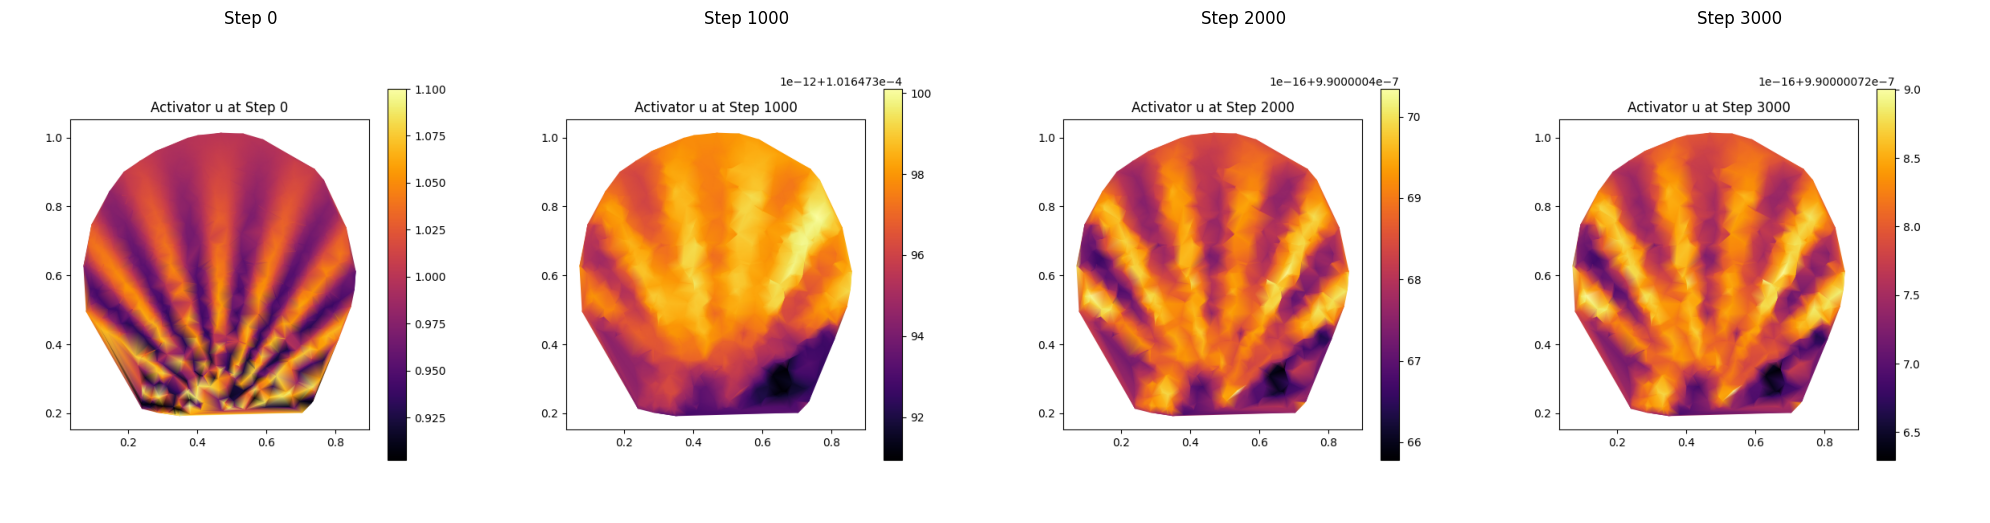

<Figure size 640x480 with 0 Axes>

In [ ]:

iters_3 = [0, 1000, 2000, 3000]
fig_ranges = []

step_to_index = {t: i for i, t in enumerate(range(0, T + 1, 500))}

for t in iters_3:
    index = step_to_index[t]
    fig_ranges.append(snapshots[index])

fig, axs = plt.subplots(1, len(iters_3), figsize=(20, 6))
for ax, img, step in zip(axs, fig_ranges, iters_3):
    ax.imshow(img)
    ax.set_title(f"Step {step}")
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("snapshots.png")

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim

class GM_Params(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_Da = nn.Parameter(torch.log(torch.tensor(0.005)))
        self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.05)))
        self.log_rho = nn.Parameter(torch.log(torch.tensor(1.0)))
        self.log_ku  = nn.Parameter(torch.log(torch.tensor(0.03)))
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.01)))
        self.log_mu = nn.Parameter(torch.log(torch.tensor(0.1)))

    def forward(self):
        return {
            'Du': torch.exp(self.log_Da),
            'Dv': torch.exp(self.log_Dv),
            'rho': torch.exp(self.log_rho),
            'ku':  torch.exp(self.log_ku),
            'kappa': torch.exp(self.log_kappa),
            'mu':  torch.exp(self.log_mu)
        }

def fem_gm_forward(u0, v0, M, K, params, dt=0.1, T=3000):
    u, v = u0.clone(), v0.clone()
    eps = 1e-6
    for t in range(T):
        vu2 = v**2
        f_u = params['rho'] * (vu2 - params['ku'] * u)
        f_v = params['rho'] * (vu2 / (u * (1 + params['kappa'] * vu2) + eps) - params['mu'] * v)

        A_u = M + dt * params['Du'] * K
        A_v = M + dt * params['Dv'] * K
        b_u = M @ u + dt * (M @ f_u)
        b_v = M @ v + dt * (M @ f_v)

        u = torch.linalg.solve(A_u, b_u)
        v = torch.linalg.solve(A_v, b_v)
    return u

def train_fem_pinn(a0, b0, M, K, real_img, total_count_iterations=200):
    model = GM_Params()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(total_count_iterations):
        optimizer.zero_grad()
        params = model()
        u_pred = fem_gm_forward(a0, b0, M, K, params, dt=0.1, T=3000)
        loss = torch.mean((u_pred - real_img)**2)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            print({k: v.item() for k, v in params.items()})
    return model


In [ ]:


import torch
import numpy as np
import cv2


a0_np, h0_np = initialize_fowler_pattern(points)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a0_torch = torch.tensor(a0_np, dtype=torch.float32, device=device)
h0_torch = torch.tensor(h0_np, dtype=torch.float32, device=device)


M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

new_intensity_pattern = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
values_gray_for_new = gray_shell * new_intensity_pattern
normalized_int = values_gray_for_new / 255.0

h_img, w_img = new_intensity_pattern.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(normalized_int[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

a0_torch.shape, h0_torch.shape, M_torch.shape, interior_target.shape


(torch.Size([1174]),
 torch.Size([1174]),
 torch.Size([1174, 1174]),
 torch.Size([1174]))

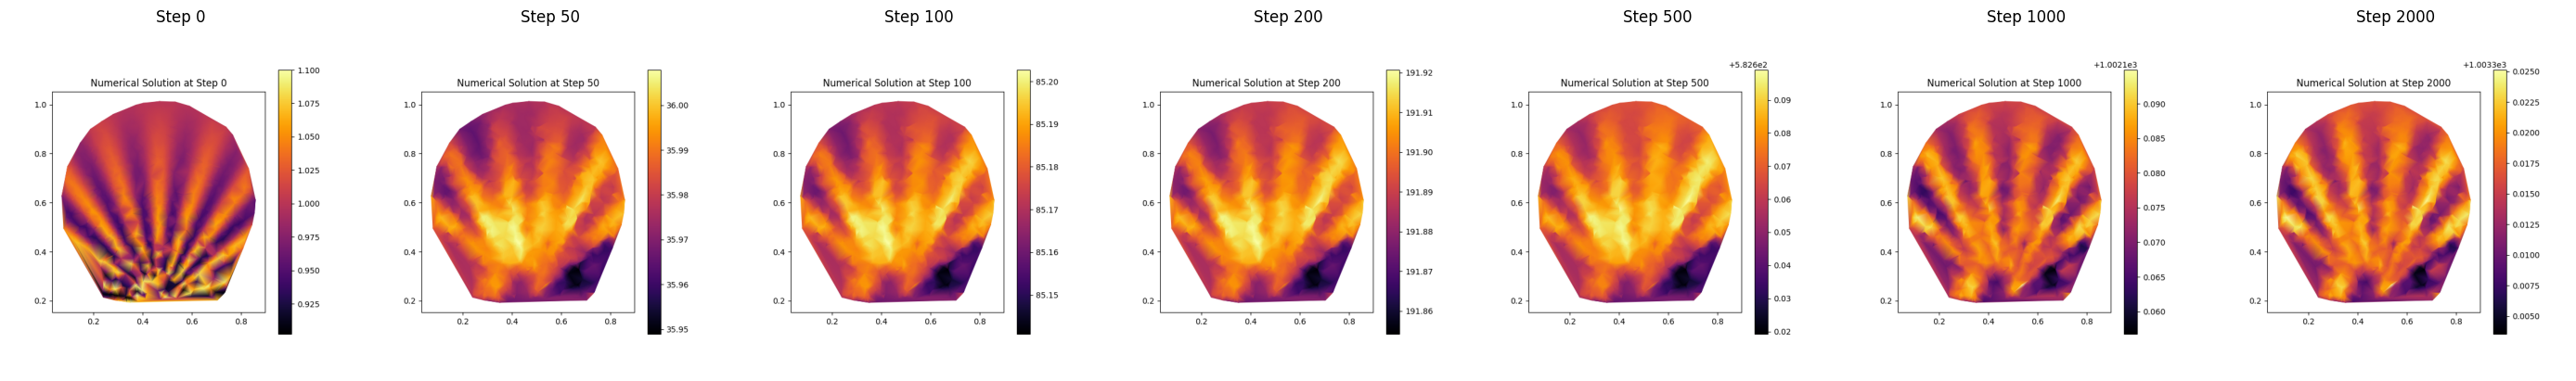

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import matplotlib.tri as mtri
import cv2
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import cv2
import numpy as np
from scipy.spatial import Delaunay

image_path = 'image2.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

h, w = shell_mask.shape
ratio_between_points = h / w

num_points = 3000
np.random.seed(0)
meshes_tri_generated_randpoint = np.random.rand(num_points, 2)
meshes_tri_generated_randpoint[:, 1] *= ratio_between_points

px = (meshes_tri_generated_randpoint[:, 0] * w).astype(int)
py = ((ratio_between_points - meshes_tri_generated_randpoint[:, 1]) * h / ratio_between_points).astype(int)


px = np.clip(px, 0, w - 1)
py = np.clip(py, 0, h - 1)

bl2 = shell_mask[py, px] > 0
points = meshes_tri_generated_randpoint[bl2]

tri = Delaunay(points)
triangles = tri.simplices


def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    sized_x_axis_below = np.mean(points[:, 0])
    sized_y_axis_below = np.min(points[:, 1])
    center = np.array([sized_x_axis_below, sized_y_axis_below])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)

        multified_coef_vert = (y - sized_y_axis_below) / (np.max(points[:, 1]) - sized_y_axis_below + 1e-6)
        pert_term_additional = (1 - multified_coef_vert)
        perturb = 0.1 * np.cos(20 * angle) * pert_term_additional

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)


def fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + kappa * a2 + rho0)) / (h + h0)  - mu * a
    inhibition = sigma + rho * (a2 / (1 + kappa * a2)) - eta * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new


Da = 0.015
Dh = 0.0
kappa = 0.1
sigma = 0.0001
rho0 = 0.1
mu = 1e-6
rho = 0.0002
eta = 0.014
h0 = 0.1
dt = 0.1
T = 3000

save_steps = [0, 50, 100, 200, 500, 1000, 2000]

snapshots = []

for t in range(T + 1):
    if t in save_steps:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(tri_meshes_count, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Numerical Solution at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        image_rgb = image[:, :, :3]
        snapshots.append(PIL.Image.fromarray(image_rgb))
        plt.close(fig)

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt)


fig, axes = plt.subplots(1, len(snapshots), figsize=(4 * len(snapshots), 4))

for i, ax in enumerate(axes):
    ax.imshow(snapshots[i])
    ax.set_title(f"Step {save_steps[i]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("combined_snapshots.png")
plt.show()


In [ ]:
u0_np, v0_np = initialize_fowler_pattern(points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u0_torch = torch.tensor(u0_np, dtype=torch.float32, device=device)
v0_torch = torch.tensor(v0_np, dtype=torch.float32, device=device)

M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)


new_intensity_pattern = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
values_gray_for_new = gray_shell * new_intensity_pattern
normalized_int = values_gray_for_new / 255.0

emphasized = 1.0 - normalized_int

h_img, w_img = new_intensity_pattern.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(emphasized[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

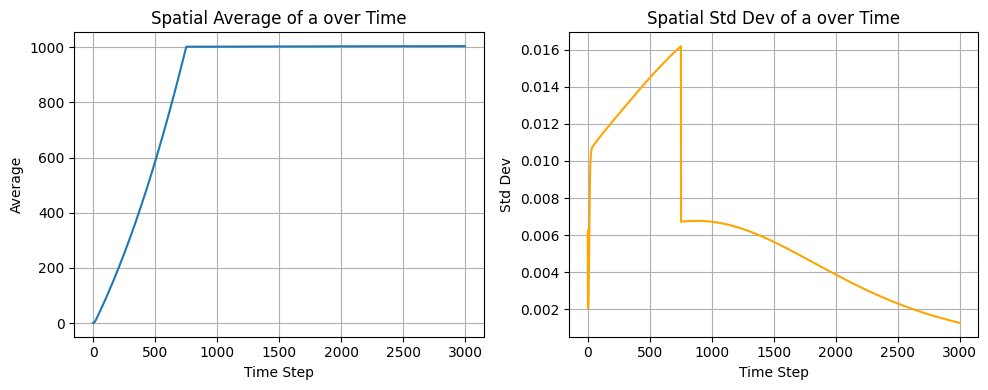

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import cv2
import matplotlib.tri as mtri
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_path = 'image2.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

h, w = shell_mask.shape
ratio_between_points = h / w

num_points = 3000
np.random.seed(0)
meshes_tri_generated_randpoint = np.random.rand(num_points, 2)
meshes_tri_generated_randpoint[:, 1] *= ratio_between_points

px = (meshes_tri_generated_randpoint[:, 0] * w).astype(int)
py = ((ratio_between_points - meshes_tri_generated_randpoint[:, 1]) * h / ratio_between_points).astype(int)

px = np.clip(px, 0, w - 1)
py = np.clip(py, 0, h - 1)

bl2 = shell_mask[py, px] > 0
points = meshes_tri_generated_randpoint[bl2]

tri = Delaunay(points)
triangles = tri.simplices

def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    sized_x_axis_below = np.mean(points[:, 0])
    sized_y_axis_below = np.min(points[:, 1])
    center = np.array([sized_x_axis_below, sized_y_axis_below])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)


        multified_coef_vert = (y - sized_y_axis_below) / (np.max(points[:, 1]) - sized_y_axis_below + 1e-6)
        pert_term_additional = (1 - multified_coef_vert)
        perturb = 0.1 * np.cos(20 * angle) * pert_term_additional

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)

def fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + kappa * a2 + rho0)) / (h + h0)  - mu * a
    inhibition = sigma + rho * (a2 / (1 + kappa * a2)) - eta * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new

Da = 0.015
Dh = 0.0
kappa = 0.1
sigma = 0.0001
rho0 = 0.1
mu = 1e-6
rho = 0.0002
eta = 0.014
h0 = 0.1
dt = 0.1
T = 3000




import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

snapshots = []
avg_a = []
std_a = []

for t in range(T + 1):
    if t in [0, 50, 200, 1000, 2000]:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)

        tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(tri_meshes_count, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator a at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.savefig(f"second_step_{t}.png")
        plt.close(fig)

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt)
        avg_a.append(np.mean(a))
        std_a.append(np.std(a))


snapshots[-1]

iterations_over_time = np.arange(0, T)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(iterations_over_time, avg_a, label='Spatial Average of a')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of a over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iterations_over_time, std_a, label='Spatial Std Dev of a', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of a over Time')
plt.grid(True)

plt.tight_layout()
plt.show()



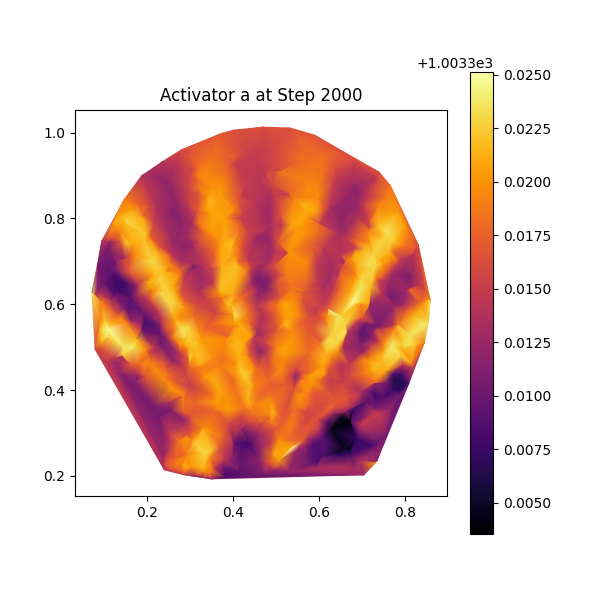

In [71]:

snapshots[-1]

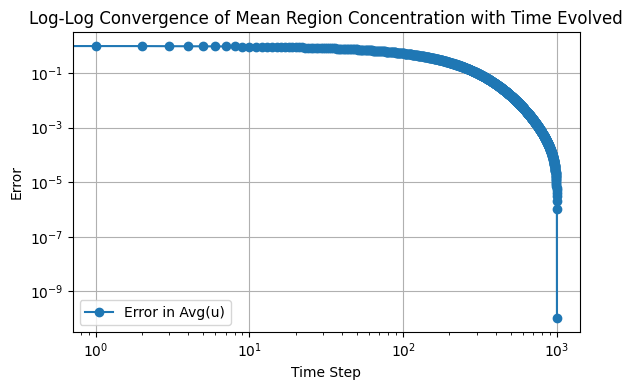

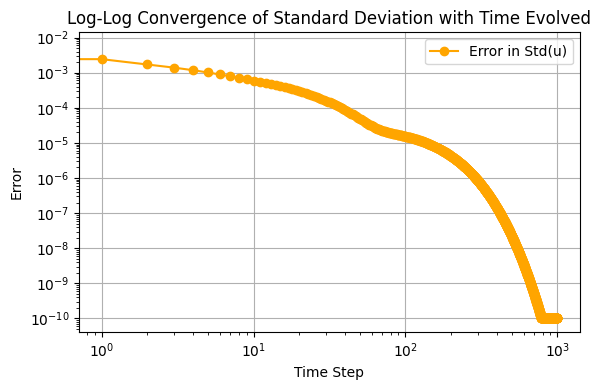

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

corresp_values1 = 1000
corresp_avg = avg_u[corresp_values1]
corresp_std = std_u[corresp_values1]

iterations_over_time2 = np.arange(0, corresp_values1 + 1)

errors_avg = np.abs(np.array(avg_u[:corresp_values1 + 1]) - corresp_avg)
errors_std = np.abs(np.array(std_u[:corresp_values1 + 1]) - corresp_std)

errors_avg = np.clip(errors_avg, 1e-10, None)
errors_std = np.clip(errors_std, 1e-10, None)

plt.figure(figsize=(6, 4))
plt.loglog(iterations_over_time2, errors_avg, label='Error in Avg(u)', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Mean Region Concentration with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.loglog(iterations_over_time2, errors_std, label='Error in Std(u)', marker='o', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Standard Deviation with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


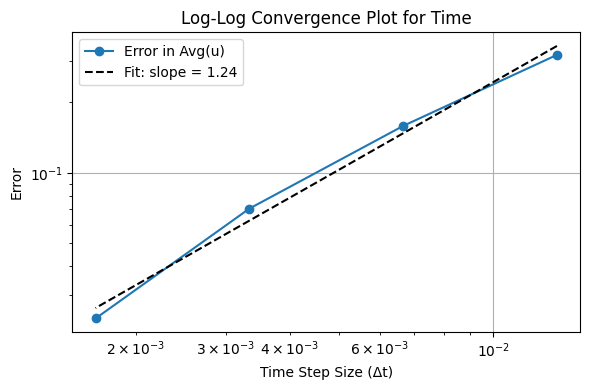

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iter_over_time_list = [75, 150, 300, 600, 1200]
last_avg_values = []

for num_steps in iter_over_time_list:
    dt = 1.0 / num_steps
    u, v = initialize_fowler_pattern(points)
    for t in range(num_steps):
        u, v = fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)
    last_avg_values.append(np.mean(u))

ref_value = last_avg_values[-1]
errors = [abs(val - ref_value) for val in last_avg_values[:-1]]

dt_list = [1.0 / n for n in iter_over_time_list[:-1]]

log_dt = np.log(dt_list)
log_err = np.log(errors)
slope, intercept = np.polyfit(log_dt, log_err, 1)
fit_line = np.exp(intercept) * np.array(dt_list)**slope

plt.figure(figsize=(6, 4))
plt.loglog(dt_list, errors, 'o-', label='Error in Avg(u)')
plt.loglog(dt_list, fit_line, 'k--', label=f'Fit: slope = {slope:.2f}')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Error')
plt.title('Log-Log Convergence Plot for Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


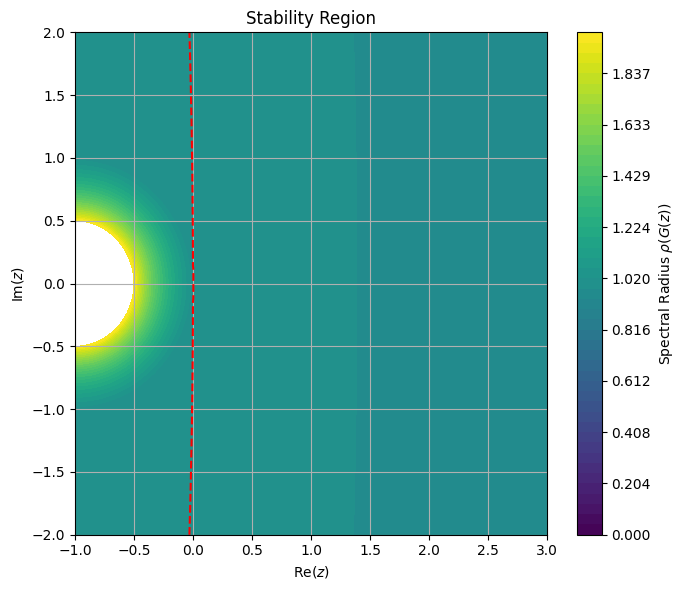

In [ ]:
def stability_model_check_out(mu2, eta, sigma, rho, rho0, kappa, h0, u0=0.1, tol=1e-10, max_iter=1000):
    u = u0
    for i in range(max_iter):
        v = (sigma + rho * u**2 / (1 + kappa * u**2)) / eta
        u_next = (mu2 / rho) * (v + h0) * (1 + kappa * u**2 + rho0)

        if abs(u_next - u) < tol:
            return u_next, i
        u = u_next
    raise RuntimeError("Fixed-point iteration did not converge")

mu2 = 1e-6
eta = 0.014
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 0.1
h0 = 0.1


u_star, num_iters = stability_model_check_out(mu2, eta, sigma, rho, rho0, kappa, h0)
v_star = (sigma + rho * u_star**2 / (1 + kappa * u_star**2)) / eta

u_star, v_star, num_iters

from numpy.linalg import eigvals

u_star = 6.600000239842878e-06
v_star = 0.5000000217800016

mu2 = 1e-6
eta = 0.014
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1
dt = 0.1

B = 1 + kappa * u_star**2
a = mu2 * ((2 * (1 + rho)) / B - 1)
b = -mu2 * u_star / (v_star + h0)
c = (2 * rho * u_star) / (1 + kappa * u_star**2)**2
d = -eta

J = np.array([[a, b],
              [c, d]])
D = np.diag([0.015, 1.0])


x_vals = np.linspace(-1, 3, 300)
y_vals = np.linspace(-2, 2, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y


rho_value_mesh = np.zeros_like(X)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        z = Z[i, j]
        try:
            G = np.linalg.inv(np.eye(2) + z * D) @ (np.eye(2) + dt * J)
            eigs = eigvals(G)
            rho_value_mesh[i, j] = max(abs(eigs))
        except np.linalg.LinAlgError:
            rho_value_mesh[i, j] = np.inf

levels = np.linspace(0, 2, 50)
plt.figure(figsize=(7, 6))
contourf = plt.contourf(X, Y, rho_value_mesh, levels=levels, cmap='viridis')
plt.contour(X, Y, rho_value_mesh, levels=[1], colors='red', linewidths=1.5, linestyles='--')

corresp_bars = plt.colorbar(contourf)
corresp_bars.set_label('Spectral Radius $\\rho(G(z))$')

plt.xlabel('Re$(z)$')
plt.ylabel('Im$(z)$')
plt.title('Stability Region')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
u0_np, v0_np = initialize_fowler_pattern(points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u0_torch = torch.tensor(u0_np, dtype=torch.float32, device=device)
v0_torch = torch.tensor(v0_np, dtype=torch.float32, device=device)

M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

new_intensity_pattern = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
values_gray_for_new = gray_shell * new_intensity_pattern
normalized_int = values_gray_for_new / 255.0

emphasized = 1.0 - normalized_int

h_img, w_img = new_intensity_pattern.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(emphasized[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

In [ ]:
import torch
import numpy as np
import cv2
h = int(shell_mask.shape[0])
w = int(shell_mask.shape[1])

new_gray = cv2.resize(gray_shell, (int(w), int(h)), interpolation=cv2.INTER_LINEAR)

normalized_new_gray= new_gray.astype(np.float32) / 255.0

new_intensity_pattern = cv2.resize(shell_mask, (w, h), interpolation=cv2.INTER_NEAREST)
masked_pattern = normalized_new_gray* new_intensity_pattern

pattern_modif_intensity = 1.0 - np.sqrt(masked_pattern)
pattern_modif_intensity = np.clip(pattern_modif_intensity, 0, 1)

interior_data = []
for x, y in points:
    ix = int(x * w)
    iy = int((1.0 - y) * h)
    ix = np.clip(ix, 0, w - 1)
    iy = np.clip(iy, 0, h - 1)
    interior_data.append(pattern_modif_intensity[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)



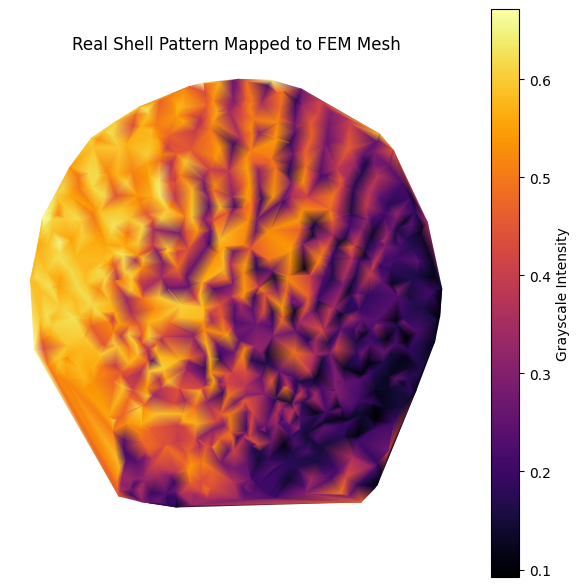

((1174, 2), (1174,))

In [ ]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

path_fig = "image2.jpg"
img = cv2.imread(path_fig)
gray_shell = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, shell_mask = cv2.threshold(gray_shell, 10, 255, cv2.THRESH_BINARY)
shell_mask = shell_mask // 255

h, w = shell_mask.shape
ratio_between_points = h / w

num_points = 3000
np.random.seed(0)
meshes_tri_generated_randpoint = np.random.rand(num_points, 2)
meshes_tri_generated_randpoint[:, 1] *= ratio_between_points

px = (meshes_tri_generated_randpoint[:, 0] * w).astype(int)
py = ((ratio_between_points - meshes_tri_generated_randpoint[:, 1]) * h / ratio_between_points).astype(int)
px = np.clip(px, 0, w - 1)
py = np.clip(py, 0, h - 1)

bl2 = shell_mask[py, px] > 0
points = meshes_tri_generated_randpoint[bl2]

tri = Delaunay(points)
triangles = tri.simplices

new_gray = cv2.resize(gray_shell, (w, h), interpolation=cv2.INTER_LINEAR)
normalized_new_gray= new_gray.astype(np.float32) / 255.0

mask_resized = cv2.resize((shell_mask * 255).astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
mask_resized = mask_resized // 255

masked_pattern = normalized_new_gray* mask_resized

pattern_modif_intensity = 1.0 - masked_pattern ** 0.7
pattern_modif_intensity = np.clip(pattern_modif_intensity, 0, 1)

intensity_values = []
for x, y in points:
    ix = int(x * w)
    iy = int((ratio_between_points - y) * h / ratio_between_points)
    ix = np.clip(ix, 0, w - 1)
    iy = np.clip(iy, 0, h - 1)
    intensity_values.append(pattern_modif_intensity[iy, ix])

intensity_values = np.array(intensity_values)

interior_target = torch.tensor(intensity_values, dtype=torch.float32, device=device)


tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
plt.figure(figsize=(6, 6))
plt.tripcolor(tri_meshes_count, intensity_values, shading='gouraud', cmap='inferno')
plt.gca().set_aspect('equal')
plt.title("Real Shell Pattern Mapped to FEM Mesh")
plt.colorbar(label='Grayscale Intensity')
plt.axis('off')
plt.tight_layout()
plt.show()

points.shape, intensity_values.shape



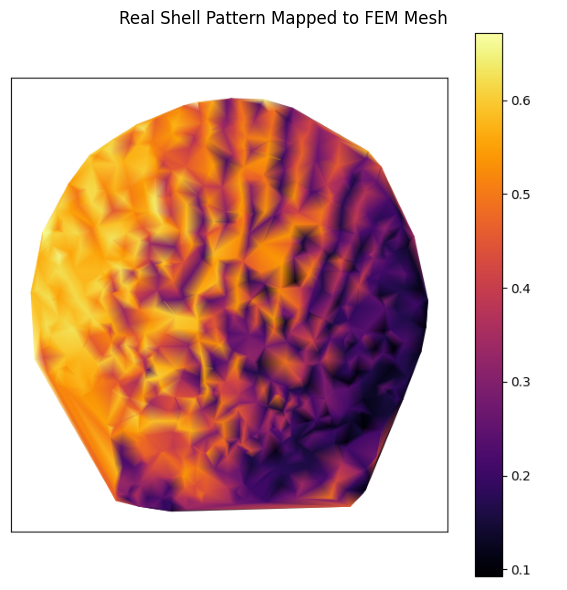

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import PIL.Image

vmin = intensity_values.min()
vmax = intensity_values.max()

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
FigureCanvas(fig)

tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)

im = ax.tripcolor(tri_meshes_count, intensity_values, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)

ax.set_aspect('equal')
plt.colorbar(im, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout(pad=0.1)

fig.canvas.draw()
image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
real_image = PIL.Image.fromarray(image[:, :, :3])
plt.close(fig)

plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(real_image)
plt.axis('off')
plt.title("Real Shell Pattern Mapped to FEM Mesh")
plt.tight_layout()
plt.show()

real_image.save("real_shell_pattern_clean.png")



Matrix M shape: torch.Size([1174, 1174])
Initial u shape: torch.Size([1174])
Real image target shape: torch.Size([1174])
Epoch 0: L_total = 0.444797, L_data = 0.437721, L_phys = 0.007077
Epoch 10: L_total = 0.316019, L_data = 0.313019, L_phys = 0.003000
Epoch 20: L_total = 0.217592, L_data = 0.215558, L_phys = 0.002035
Epoch 30: L_total = 0.145288, L_data = 0.143660, L_phys = 0.001627
Epoch 40: L_total = 0.095018, L_data = 0.093673, L_phys = 0.001346
Epoch 50: L_total = 0.061741, L_data = 0.060801, L_phys = 0.000940
Epoch 60: L_total = 0.040855, L_data = 0.040167, L_phys = 0.000688
Epoch 70: L_total = 0.028104, L_data = 0.027590, L_phys = 0.000513
Epoch 80: L_total = 0.020464, L_data = 0.020006, L_phys = 0.000458
Epoch 90: L_total = 0.015863, L_data = 0.015435, L_phys = 0.000428
Epoch 100: L_total = 0.013058, L_data = 0.012694, L_phys = 0.000364
Epoch 110: L_total = 0.011397, L_data = 0.011078, L_phys = 0.000319
Epoch 120: L_total = 0.010467, L_data = 0.010145, L_phys = 0.000322
Epoch 

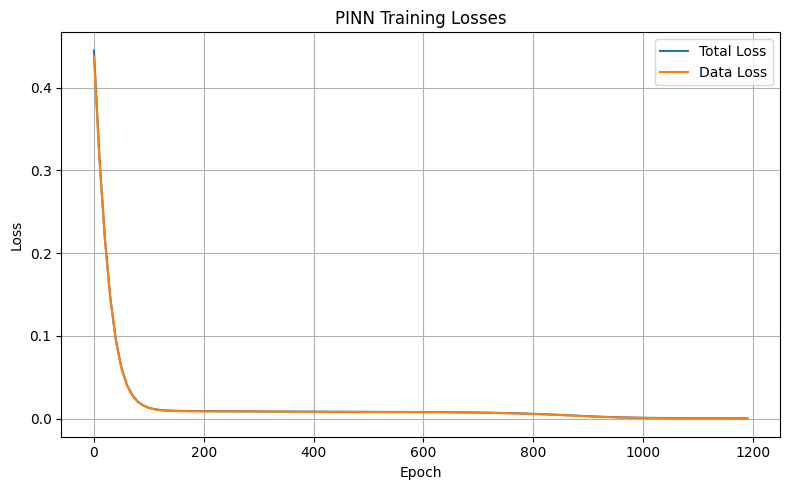

In [ ]:
def train_fem_pinn_with_initial_learning(u0, v0, M, K, real_img, total_count_iterations=300, dt=0.01, T=50):
    class FowlerParams(nn.Module):
        def __init__(self):
            super().__init__()
            self.log_Du = nn.Parameter(torch.log(torch.tensor(0.015)))
            self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.001)))
            self.log_rho = nn.Parameter(torch.log(torch.tensor(0.1)))
            self.log_kappa = nn.Parameter(torch.log(torch.tensor(1.0)))
            self.log_rho0 = nn.Parameter(torch.log(torch.tensor(0.05)))
            self.log_mu2 = nn.Parameter(torch.log(torch.tensor(1e-6)))
            self.log_sigma = nn.Parameter(torch.log(torch.tensor(0.0001)))
            self.log_eta = nn.Parameter(torch.log(torch.tensor(0.0002)))
            self.h0 = 0.1

        def forward(self):
            return {
                'Du': torch.exp(self.log_Du),
                'Dv': torch.exp(self.log_Dv),
                'rho': torch.exp(self.log_rho),
                'kappa': torch.exp(self.log_kappa),
                'rho0': torch.exp(self.log_rho0),
                'mu2': torch.exp(self.log_mu2),
                'sigma': torch.exp(self.log_sigma),
                'eta': torch.exp(self.log_eta),
                'h0': self.h0
            }

    model = FowlerParams().to(u0.device)

    u0_param = nn.Parameter(u0.clone().detach())
    v0_param = nn.Parameter(v0.clone().detach())

    optimizer = optim.Adam(list(model.parameters()) + [u0_param, v0_param], lr=1e-2)
    total_loss_list1 = {'epoch': [], 'total': [], 'data': []}
    for epoch in range(total_count_iterations):
        optimizer.zero_grad()
        params = model()

        u, v = u0_param, v0_param
        loss_phys = 0

        for t in range(T):
            u2 = u**2
            activation = (params['rho'] * u2) / ((v + params['h0']) * (1 + params['kappa'] * u2 + params['rho0']) + 1e-6) - params['mu2'] * u
            inhibition = params['sigma'] + (params['rho'] * u2) / (1 + params['kappa'] * u2 + 1e-6) - params['eta'] * v

            A_u = M + dt * params['Du'] * K
            A_v = M + dt * params['Dv'] * K
            b_u = M @ u + dt * (M @ activation)
            b_v = M @ v + dt * (M @ inhibition)

            u_new = torch.linalg.solve(A_u, b_u)
            v_new = torch.linalg.solve(A_v, b_v)

            Ru = (M @ (u_new - u) / dt) + params['Du'] * (K @ u_new) - (M @ activation)
            Rv = (M @ (v_new - v) / dt) + params['Dv'] * (K @ v_new) - (M @ inhibition)
            loss_phys += (torch.norm(Ru)**2 + torch.norm(Rv)**2) * 1e8

            u, v = u_new, v_new

        loss_data = torch.mean((u - real_img) ** 2)
        loss_total = loss_data + loss_phys
        loss_total.backward()
        optimizer.step()


        if epoch % 10 == 0:
          total_loss_list1['epoch'].append(epoch)
          total_loss_list1['total'].append(loss_total.item())
          total_loss_list1['data'].append(loss_data.item())
          print(f"Epoch {epoch}: L_total = {loss_total.item():.6f}, L_data = {loss_data.item():.6f}, L_phys = {loss_phys.item():.6f}")


    return model, u0_param.detach(), v0_param.detach(), total_loss_list1

u0_np, v0_np = initialize_fowler_pattern(points)
assert u0_np.shape == v0_np.shape == (len(points),)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u0_torch = torch.tensor(u0_np, dtype=torch.float32, device=device)
v0_torch = torch.tensor(v0_np, dtype=torch.float32, device=device)

M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

assert interior_target.shape[0] == u0_torch.shape[0], \
    f"Shape mismatch: interior_target ({interior_target.shape}) vs u0 ({u0_torch.shape})"

print("Matrix M shape:", M_torch.shape)
print("Initial u shape:", u0_torch.shape)
print("Real image target shape:", interior_target.shape)

trained_model, u0_learnable_pattern, v0_learnable_pattern, total_loss_list1 = train_fem_pinn_with_initial_learning(
    u0=u0_torch,
    v0=v0_torch,
    M=M_torch,
    K=K_torch,
    real_img=interior_target,
    total_count_iterations=1200
)

parameters_dict1 = trained_model()


plt.figure(figsize=(8, 5))
plt.plot(total_loss_list1['epoch'], total_loss_list1['total'], label='Total Loss')
plt.plot(total_loss_list1['epoch'], total_loss_list1['data'], label='Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('PINN Training Losses')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(total_loss_list1["epoch"])
print(total_loss_list1["total"])
print(total_loss_list1["data"])

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190]
[0.44479718804359436, 0.3160194754600525, 0.21759247779846191, 0.1452876627445221, 0.09501849859952927, 0.061741117388010025, 0.04085497930645943, 0.0281036589294672, 0.0204642154276371, 0.015863433480262756, 0.013057606294751167, 0.0113965580239892, 0.010467221960425377, 0.009915575385093689, 0.009591392241418362, 0.009389853104948997, 0.00924153532832861, 0.00913943350315094, 0.0090906

M shape: (1174, 1174)
K shape: (1174, 1174)
(1174, 2)
(2321, 3)


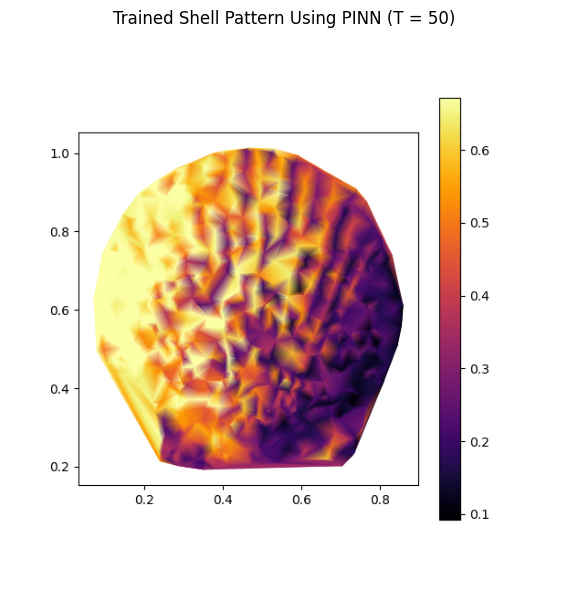

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import cv2
import matplotlib.tri as mtri
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_path = 'image2.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

h, w = shell_mask.shape
ratio_between_points = h / w

num_points = 3000
np.random.seed(0)
meshes_tri_generated_randpoint = np.random.rand(num_points, 2)
meshes_tri_generated_randpoint[:, 1] *= ratio_between_points

px = (meshes_tri_generated_randpoint[:, 0] * w).astype(int)
py = ((ratio_between_points - meshes_tri_generated_randpoint[:, 1]) * h / ratio_between_points).astype(int)

px = np.clip(px, 0, w - 1)
py = np.clip(py, 0, h - 1)

bl2 = shell_mask[py, px] > 0
points = meshes_tri_generated_randpoint[bl2]

tri = Delaunay(points)
triangles = tri.simplices


Du     = parameters_dict1['Du'].detach().cpu().item()
Dv     = parameters_dict1['Dv'].detach().cpu().item()
rho    = parameters_dict1['rho'].detach().cpu().item()
kappa  = parameters_dict1['kappa'].detach().cpu().item()
rho0   = parameters_dict1['rho0'].detach().cpu().item()
mu2    = parameters_dict1['mu2'].detach().cpu().item()
sigma  = parameters_dict1['sigma'].detach().cpu().item()
eta    = parameters_dict1['eta'].detach().cpu().item()
h0     = 0.1
dt     = 0.01
T      = 50


M, K = assemble_fem_matrices(points, triangles)
print("M shape:", M.shape)
print("K shape:", K.shape)
print(points.shape)
print(triangles.shape)

a = u0_learnable_pattern.detach().cpu().numpy()
h = v0_learnable_pattern.detach().cpu().numpy()


for t in range(T):
    a, h = fem_fowler_step(a, h, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)


fig, ax = plt.subplots(figsize=(6, 6))
FigureCanvas(fig)
tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
vmin = intensity_values.min()
vmax = intensity_values.max()

im = ax.tripcolor(tri_meshes_count, a, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)

ax.set_aspect('equal')
plt.colorbar(im, ax=ax)

fig.canvas.draw()
image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
final_image = PIL.Image.fromarray(image[:, :, :3])
plt.close(fig)

plt.figure(figsize=(6, 6))
plt.imshow(final_image)
plt.axis('off')
plt.title("Trained Shell Pattern Using PINN (T = 50)")
plt.tight_layout()
plt.show()
final_image.save("fowler_final_step_T200.png")


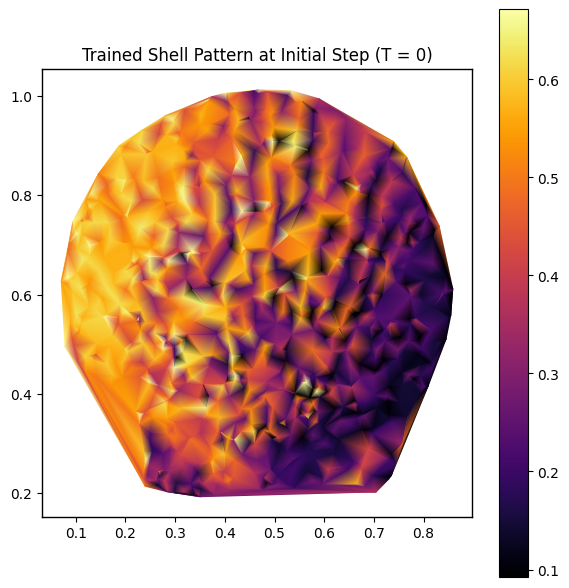

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import PIL.Image
import numpy as np

a0 = u0_learnable_pattern.detach().cpu().numpy()

tri_meshes_count = mtri.Triangulation(points[:, 0], points[:, 1], triangles)

vmin = intensity_values.min()
vmax = intensity_values.max()

fig, ax = plt.subplots(figsize=(6, 6))
FigureCanvas(fig)
im = ax.tripcolor(tri_meshes_count, a0, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title("Trained Shell Pattern at Initial Step (T = 0)")
plt.colorbar(im, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.0)

plt.tight_layout()
plt.show()

fig.canvas.draw()
image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
initial_image = PIL.Image.fromarray(image[:, :, :3])
initial_image.save("fowler_initial_step_T0.png")


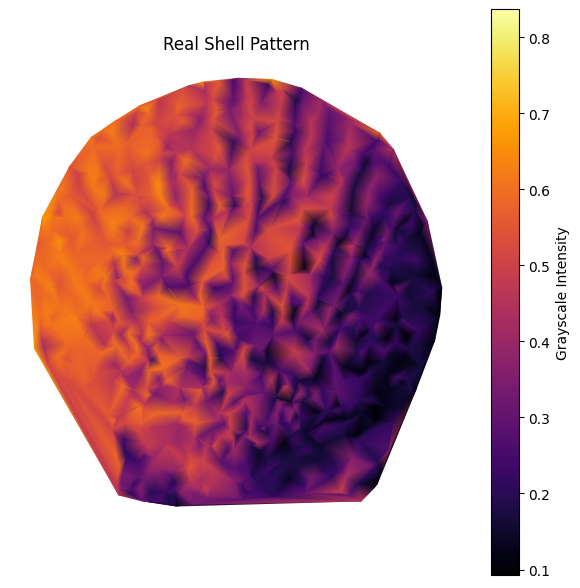

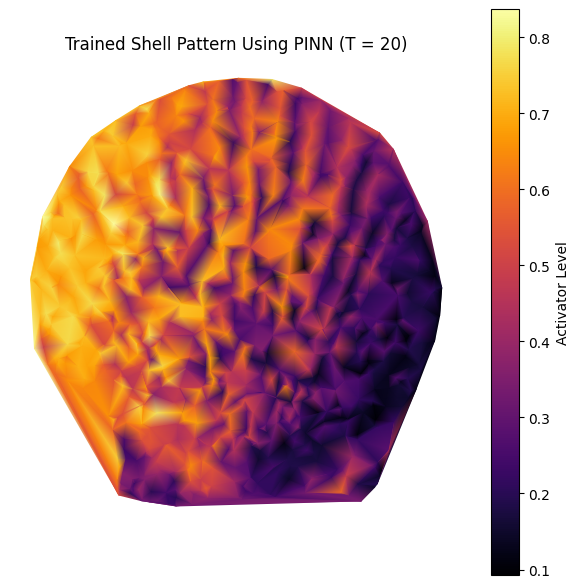

In [ ]:
vmin = min(intensity_values.min(), a.min())
vmax = max(intensity_values.max(), a.max())

plt.figure(figsize=(6, 6))
plt.tripcolor(tri_meshes_count, intensity_values, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
plt.gca().set_aspect('equal')
plt.title("Real Shell Pattern")
plt.colorbar(label='Grayscale Intensity')
plt.axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
FigureCanvas(fig)
im = ax.tripcolor(tri_meshes_count, a, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title("Trained Shell Pattern Using PINN (T = 20)")
plt.colorbar(im, ax=ax, label='Activator Level')
plt.axis('off')
plt.tight_layout()
plt.show()




In [ ]:
parameters_dict1

{'Du': tensor(8.9874e-06, device='cuda:0', grad_fn=<ExpBackward0>),
 'Dv': tensor(1.4880e-05, device='cuda:0', grad_fn=<ExpBackward0>),
 'rho': tensor(0.0666, device='cuda:0', grad_fn=<ExpBackward0>),
 'kappa': tensor(1.4409, device='cuda:0', grad_fn=<ExpBackward0>),
 'rho0': tensor(0.0812, device='cuda:0', grad_fn=<ExpBackward0>),
 'mu2': tensor(1.7759e-06, device='cuda:0', grad_fn=<ExpBackward0>),
 'sigma': tensor(0.0001, device='cuda:0', grad_fn=<ExpBackward0>),
 'eta': tensor(0.0002, device='cuda:0', grad_fn=<ExpBackward0>),
 'h0': 0.1}